In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, classification_report

from sklearn.tree import DecisionTreeClassifier

from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from sklearn.datasets import make_classification

import string

In [2]:
X,y = make_classification(n_samples=50_000, n_features=10, n_informative=3, n_classes=2, weights=[.95])

In [3]:
column_names = ['num__' + str(x) for x in range(1,11)]

In [4]:
column_names

['num__1',
 'num__2',
 'num__3',
 'num__4',
 'num__5',
 'num__6',
 'num__7',
 'num__8',
 'num__9',
 'num__10']

In [5]:
column_names.append('target')

In [6]:
pd.Series(y)

0        0
1        1
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    1
49999    0
Length: 50000, dtype: int32

In [7]:
df = pd.concat([pd.DataFrame(X),pd.Series(y)], axis=1)
df.columns = column_names

In [8]:
df.head()

,num__1,num__2,num__3,num__4,num__5,num__6,num__7,num__8,num__9,num__10,target
0,2.160495,-1.489719,0.549858,0.940609,-0.457104,-0.673613,-0.883758,-0.964928,-2.140907,1.079666,0
1,0.293864,-1.689099,0.714612,-0.327861,-0.083969,-1.275394,-0.886173,0.937092,-0.926793,1.259254,1
2,2.431626,0.665641,-0.529497,0.653789,-0.499014,1.611521,-0.556095,-0.525092,-1.833917,1.423048,0
3,-0.041051,0.115691,0.683815,1.146465,0.077709,1.992676,-0.448109,-1.289473,-0.491581,-1.036866,0
4,-0.419081,0.716884,1.020900,-0.056527,-0.628421,0.424612,-2.048719,-1.784695,-3.861840,1.437247,0


In [9]:
df['cat_1'] = np.random.choice(a=['a','b','c','d','e'],  size=len(df))
df['cat_2'] = np.random.choice(a=['f','g','h','i'],  size=len(df))

In [10]:
df.head()

,num__1,num__2,num__3,num__4,num__5,num__6,num__7,num__8,num__9,num__10,target,cat_1,cat_2
0,2.160495,-1.489719,0.549858,0.940609,-0.457104,-0.673613,-0.883758,-0.964928,-2.140907,1.079666,0,e,h
1,0.293864,-1.689099,0.714612,-0.327861,-0.083969,-1.275394,-0.886173,0.937092,-0.926793,1.259254,1,e,g
2,2.431626,0.665641,-0.529497,0.653789,-0.499014,1.611521,-0.556095,-0.525092,-1.833917,1.423048,0,d,i
3,-0.041051,0.115691,0.683815,1.146465,0.077709,1.992676,-0.448109,-1.289473,-0.491581,-1.036866,0,b,i
4,-0.419081,0.716884,1.020900,-0.056527,-0.628421,0.424612,-2.048719,-1.784695,-3.861840,1.437247,0,a,f


In [11]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [12]:
X = df.drop('target',axis =1)
y = df.target

In [13]:
# holdout split. I will call this validation
X_train_both, X_val, y_train_both, y_val = train_test_split(X,y,random_state=42, test_size = .1)

In [14]:
# Sniff Test
y_val.value_counts(normalize=True)

0    0.9496
1    0.0504
Name: target, dtype: float64

In [15]:
y_train_both.value_counts(normalize=True)

0    0.945444
1    0.054556
Name: target, dtype: float64

In [16]:
# Now, create my test and train splits for model creation, default test size
X_train, X_test, y_train, y_test = train_test_split(X_train_both, y_train_both, random_state=42)

In [17]:
print(f'Train size:     {X_train.shape}')
print(f'Test size:      {X_test.shape}')
print(f'Validation size {X_val.shape}')

Train size:     (33750, 12)
Test size:      (11250, 12)
Validation size (5000, 12)


In [18]:
# cat and numeric subpipe

subpipe_numerics = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy='median')),
    ('ss', StandardScaler())
])


subpipe_cat = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [19]:
# Column Transformer

CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include=object))
], remainder='passthrough')

In [20]:
y_train.value_counts(normalize=True)

0    0.944919
1    0.055081
Name: target, dtype: float64

In [21]:
# Dummy!
dummy_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [22]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020073EBAAF0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

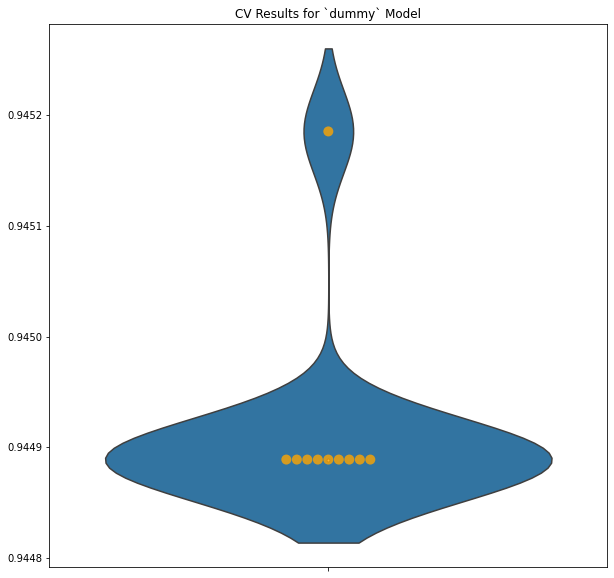

In [31]:
# Cross Validated on Training Data
dummy_model = ModelWithCV(
    dummy_model_pipe,
    model_name='dummy',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

dummy_model.plot_cv(ax=ax)

In [32]:
dummy_model.print_cv_summary()

CV Results for `dummy` model:
            0.94492 ± 0.00009 accuracy
        


In [33]:
dummy_model_pipe.score(X_test, y_test)

0.9470222222222222

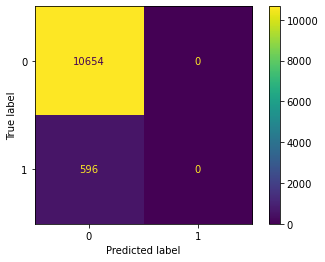

In [34]:
plot_confusion_matrix(dummy_model_pipe, X_test, y_test);

In [35]:
y_pred = dummy_model_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     10654
           1       0.00      0.00      0.00       596

    accuracy                           0.95     11250
   macro avg       0.47      0.50      0.49     11250
weighted avg       0.90      0.95      0.92     11250



C:\Users\david\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


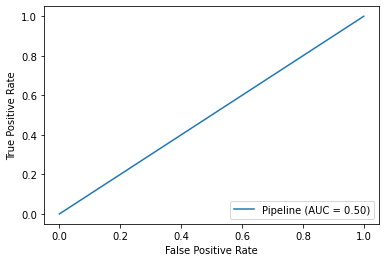

In [36]:
plot_roc_curve(dummy_model_pipe, X_test, y_test);

In [37]:
# FSM!

In [43]:
base_log_reg_pipe = Pipeline(steps=[
    ('ct',CT),
    ('base_log_reg', LogisticRegression(random_state=42))
])

In [44]:
base_log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020073EBAAF0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

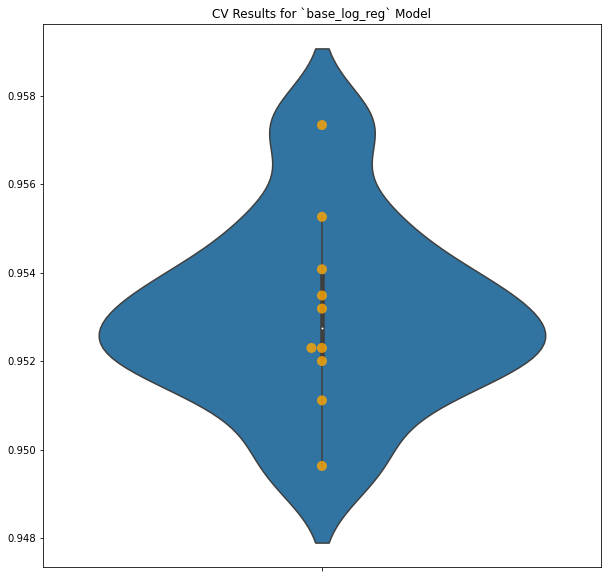

In [45]:
base_log_reg = ModelWithCV(
    base_log_reg_pipe,
    model_name='base_log_reg',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

base_log_reg.plot_cv(ax=ax);

In [46]:
base_log_reg.print_cv_summary()

CV Results for `base_log_reg` model:
            0.95307 ± 0.00205 accuracy
        


In [47]:
base_log_reg_pipe.score(X_test, y_test)

0.9550222222222222

In [48]:
y_pred = base_log_reg_pipe.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     10654
           1       0.85      0.18      0.30       596

    accuracy                           0.96     11250
   macro avg       0.90      0.59      0.64     11250
weighted avg       0.95      0.96      0.94     11250



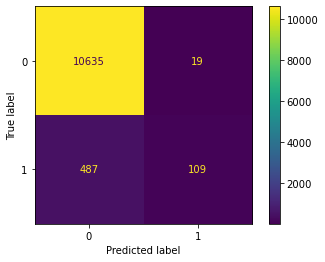

In [50]:
plot_confusion_matrix(base_log_reg_pipe, X_test, y_test)

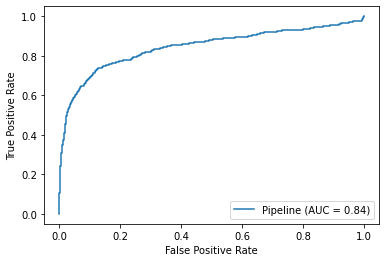

In [51]:
plot_roc_curve(base_log_reg_pipe, X_test, y_test)

In [52]:
# DT
base_dtc_pipe = Pipeline(steps=[
    ('ct',CT),
    ('base_dtc', DecisionTreeClassifier(random_state=42))
])

In [53]:
base_dtc_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020073EBAAF0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

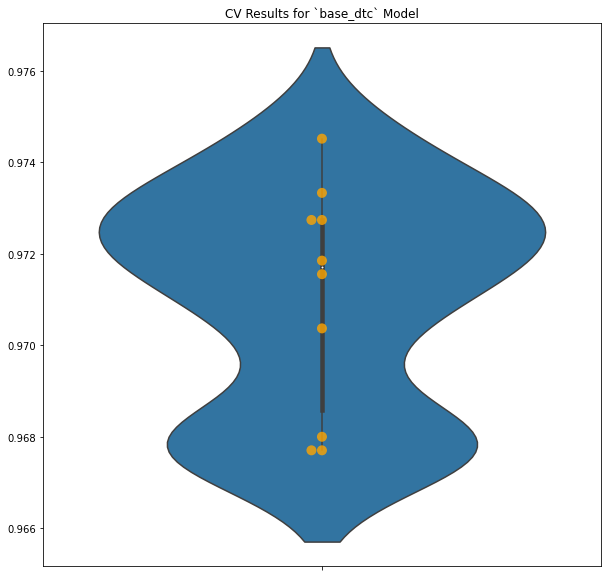

In [54]:
base_dtc = ModelWithCV(
    base_dtc_pipe,
    model_name='base_dtc',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

base_dtc.plot_cv(ax=ax);

In [55]:
base_dtc.print_cv_summary()

CV Results for `base_dtc` model:
            0.97105 ± 0.00237 accuracy
        


In [56]:
base_dtc_pipe.score(X_test, y_test)

0.9735111111111111

In [57]:
y_pred = base_dtc_pipe.predict(X_test)

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     10654
           1       0.73      0.79      0.76       596

    accuracy                           0.97     11250
   macro avg       0.86      0.89      0.87     11250
weighted avg       0.97      0.97      0.97     11250



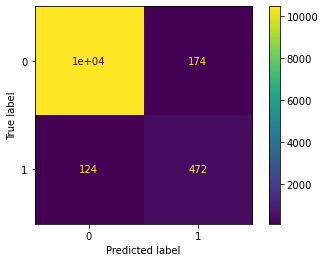

In [59]:
plot_confusion_matrix(base_dtc_pipe, X_test, y_test);

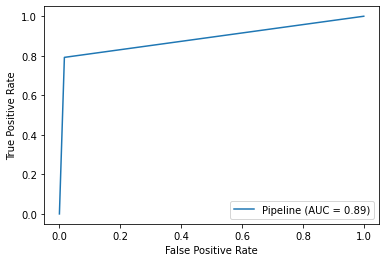

In [60]:
plot_roc_curve(base_dtc_pipe, X_test, y_test)

In [ ]:
# IMBPIPE!!!!

In [61]:
imb_pipe = ImPipeline(steps=[
    ('ct',CT),
    ('sm',SMOTE(random_state=42, sampling_strategy=.25)),
    ('dtc',DecisionTreeClassifier(random_state=42))
])

In [62]:
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020073EBAAF0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

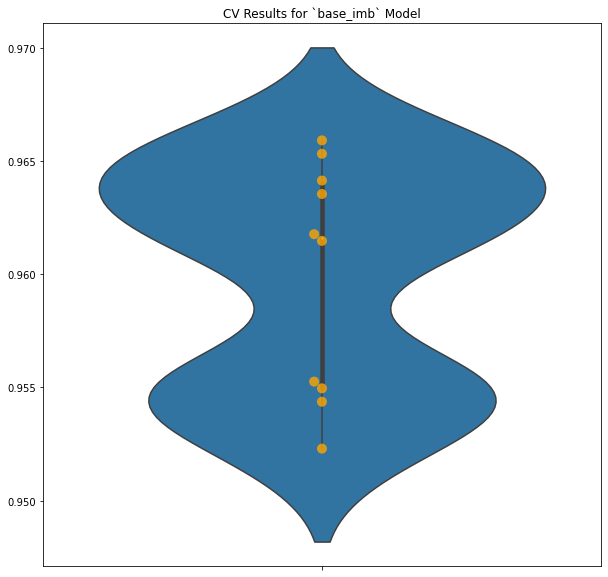

In [63]:
base_imb = ModelWithCV(
    imb_pipe,
    model_name='base_imb',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

base_imb.plot_cv(ax=ax);

In [64]:
base_imb.print_cv_summary()

CV Results for `base_imb` model:
            0.95991 ± 0.00487 accuracy
        


In [65]:
imb_pipe.score(X_test, y_test)

0.9616888888888889

In [78]:
parameters = {'dtc__criterion': ['gini', 'entropy'],
          'dtc__min_samples_leaf': [10, 15, 20],
          'sm__k_neighbors': [9, 11, 13]}

gs = GridSearchCV(estimator=imb_pipe,
                 param_grid=parameters,
                 cv=5,
                 verbose=2)

In [79]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.9s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.8s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.8s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.9s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=9, total=   0.8s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11, total=   0.9s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11, total=   0.9s
[CV] dtc__criterion=gini, dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  dtc__criterion=gini, dtc__min_samples_leaf=10, 

[CV]  dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=11, total=   1.0s
[CV] dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=11 
[CV]  dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=11, total=   0.9s
[CV] dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=13 
[CV]  dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=13, total=   1.0s
[CV] dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=13 
[CV]  dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=13, total=   0.9s
[CV] dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=13 
[CV]  dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=13, total=   0.9s
[CV] dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=13 
[CV]  dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=13, total=   0.9s
[CV] dtc__criterion=entropy, dtc__min_samples_leaf=10, sm__k_neighbors=13 
[CV]  dtc_

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.4min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x0000020073EBAAF0>),
                                                                        ('subpipe_cat',
                                                                         Pipe

In [80]:
gs.best_params_

{'dtc__criterion': 'gini', 'dtc__min_samples_leaf': 20, 'sm__k_neighbors': 13}

In [68]:
gs.best_params_

{'dtc__criterion': 'gini', 'dtc__min_samples_leaf': 10, 'sm__k_neighbors': 9}

In [81]:
gs.best_score_

0.9729777777777777

In [82]:
gs.best_estimator_.score(X_test, y_test)

0.9754666666666667

In [71]:
final_model = gs.best_estimator_

In [72]:
final_model

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020078FF56A0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [73]:
# Train with our combined train/test

final_model.fit(X_train_both, y_train_both)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020078FF56A0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

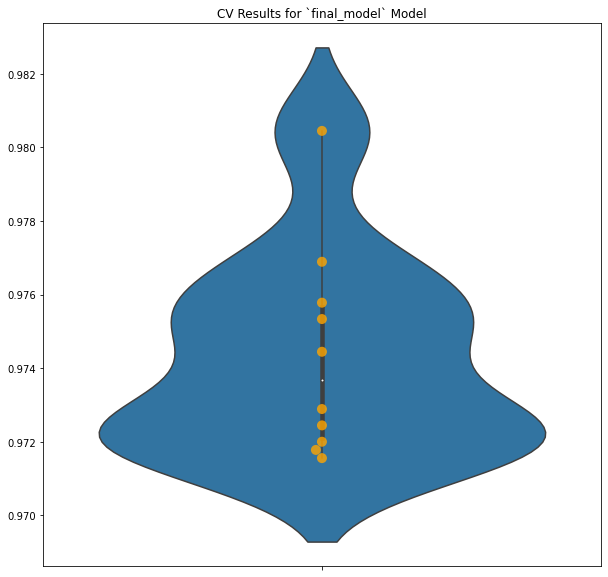

In [74]:
final_model_check = ModelWithCV(
    final_model,
    model_name='final_model',
    X=X_train_both,
    y=y_train_both)
fig, ax = plt.subplots(figsize=(10,10))

final_model_check.plot_cv(ax=ax);

In [75]:
final_model_check.print_cv_summary()

CV Results for `final_model` model:
            0.97436 ± 0.00269 accuracy
        


In [76]:
# Score against validation/hold out

final_model.score(X_val, y_val)

0.9776

In [77]:
# production model
final_model.fit(X,y)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000020078FF56A0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       